In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, fnmatch
import random as rnd
import time
import sklearn
import librosa
import scipy.signal
from scipy import interpolate
from scipy import signal
from scipy.signal import butter, filtfilt, lfilter
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

%matplotlib inline

In [2]:
datdir = "/Users/cagrierdem/Desktop/dat/guit_raw_dir/"
danceCsv = "/Users/cagrierdem/Desktop/CAVI/danceCsv/"
img_path = "/Users/cagrierdem/Desktop/dat/modelv2/plots/"
savedir = "/Users/cagrierdem/Desktop/dat/modelv2/coadaptive/npy_proc_ds_f_L/"

tasks = ["bending_soft_70",
         "bending_strong_70",
         'on-off_soft_70',
         'on-off_strong_70',
         'sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70']

elmac = 'ef-9d-fd-31-ea-10'
ermac = ['d0-8d-fc-7f-f5-f1', 'c3-0c-f3-14-d7-f0']

participant = []
for people in os.listdir(os.path.join(datdir)):
    if people.startswith('p'):
        participant.append(people)
participant = sorted(participant)

In [3]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

In [4]:
def ffind(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [5]:
def jerk_of(imudat, sr=50, normalize=True):
    
    pre_index = imudat.index
    
    xdiff = np.diff(imudat.iloc[:,4].values)
    ydiff = np.diff(imudat.iloc[:,5].values)
    zdiff = np.diff(imudat.iloc[:,6].values)
    jerk = np.sqrt(xdiff**2 + ydiff**2 + zdiff**2) / 0.005
    jerk = np.reshape(jerk, (jerk.shape[0], 1))
    
    if normalize:
        scaler = MinMaxScaler()
        scaler.fit(jerk)
        jerk_scaled = scaler.transform(jerk)
    else:
        jerk_scaled = jerk
    
    jerk_scaled = pd.DataFrame(data=jerk_scaled, columns=['jerk'])
    jerk_scaled.index = pre_index[:jerk_scaled.shape[0]]
    jerk_scaled.index.name = 'time'
        
    return jerk_scaled

### Import

In [6]:
ffind('*.csv', datdir)[:20] #limit what's displayed

['/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/emg_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_strong_70/emg_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/emg_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/bending_strong_70/emg_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_soft_70/imu_ef-9d-fd-31-ea-10.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_dir/p19/iterative_soft_70/imu_d0-8d-fc-7f-f5-f1.csv',
 '/Users/cagrierdem/Desktop/dat/guit_raw_d

In [7]:
#Find paths for improvisations
fpaths, impros=[],[]
for idx, p in enumerate(participant[:]):
    ppath = os.path.join(datdir, p)
    for t in os.listdir(ppath):
        if t.startswith('f'):
            free_path = os.path.join(ppath, t)
            fpaths.append(free_path)
            impros.append(free_path.split('/')[-1])

In [8]:
impro_tasks = list(dict.fromkeys(impros))
impro_tasks

['free_encore_100',
 'free_70',
 'free',
 'free_encore_70',
 'free_encore_90',
 'free_encore_85',
 'free_encore_120',
 'free_encore_60',
 'free_correct_70',
 'free_encore_140',
 'free_encore_110',
 'free_encore_80']

In [9]:
#All tasks + impros
start_time = time.time()

elall,erall,imulall,imurall,mtall,atall = [],[],[],[],[],[]

all_tasks=[]
all_tasks = tasks + impro_tasks

for idx, p in enumerate(participant):
  
    elpart,erpart,imulpart,imurpart,mtpart,atpart = [],[],[],[],[],[]
    
    for t in all_tasks:
        try:
            file = open(os.path.join(datdir, p, t, 'timeline.txt'), 'r')
            metro_timeline = file.read().split(',')
            metro_timeline = [float(i) for i in metro_timeline]
            file.close()
            mtpart.append(metro_timeline)
            
            file2 = open(os.path.join(datdir, p, t, 'audio_start.txt'), 'r')
            start = float(file2.read())
            file2.close
            atpart.append(start)
        
            rmac = ermac[0] if 'emg_'+ermac[0]+'.csv' in os.listdir(os.path.join(datdir, p, t+'/')) else ermac[1]
            emgl = pd.read_csv(os.path.join(datdir, p, t, 'emg_'+elmac+'.csv'), index_col=0)
            emgr = pd.read_csv(os.path.join(datdir, p, t, 'emg_'+rmac+'.csv'), index_col=0)
            emgl.index.name = 'time'
            emgr.index.name = 'time'
            elpart.append(emgl)
            erpart.append(emgr)

            imul = pd.read_csv(os.path.join(datdir, p, t, 'imu_'+elmac+'.csv'), index_col=0)
            imur = pd.read_csv(os.path.join(datdir, p, t, 'imu_'+rmac+'.csv'), index_col=0)
            imul.index.name = 'time'
            imur.index.name = 'time'
            imulpart.append(imul)
            imurpart.append(imur)
        except:
            pass

    elall.append(elpart)
    erall.append(erpart)
    imulall.append(imulpart)
    imurall.append(imurpart)
    mtall.append(mtpart)
    atall.append(atpart)
    
    printProgressBar(idx,len(participant),"completed")

print("\n")
print("Execution of this program took %s seconds." % (time.time() - start_time))

[========= ] 96%  completed

Execution of this program took 84.13320922851562 seconds.


##### Note:
One usually wants to filter first, normalize next (since the normalization may change depending on the DC response of the filter), then segment (so only the first segment(s) incur the filter's initial transient response).

In [10]:
task_qty=[]
for i,p in enumerate(participant):
    task_qty.append([p, len(erall[i])])
task_qty

[['p01', 10],
 ['p02', 9],
 ['p03', 10],
 ['p04', 10],
 ['p05', 11],
 ['p06', 10],
 ['p07', 10],
 ['p08', 11],
 ['p09', 11],
 ['p10', 11],
 ['p11', 10],
 ['p12', 11],
 ['p13', 11],
 ['p14', 10],
 ['p15', 11],
 ['p16', 10],
 ['p17', 10],
 ['p18', 10],
 ['p19', 10],
 ['p20', 10],
 ['p21', 10],
 ['p22', 10],
 ['p23', 10],
 ['p24', 11],
 ['p25', 10],
 ['p26', 10],
 ['p27', 10],
 ['p28', 10],
 ['p29', 10],
 ['p30', 11],
 ['p31', 10],
 ['p32', 10]]

### Pre-process

In [11]:
def align(df, audio_timeline, metro_timeline, beat_to_cut=7, end=False):
    
    #get the timestamp for desired beat point to cut:
    cut_point = metro_timeline[beat_to_cut] 
    
    #eliminate the lag between the metro start time and audio start time
    new_metro_timeline = [t - audio_timeline for t in metro_timeline]
    
    #cut the dataframe based on the timestamp of the chosen beat
    new_df = df[df.index >= cut_point]
    
    # reset the start index to zero by substracting the start time of the chosen beat
    s = new_df.index[0]
    new_df.index = [t - s for t in new_df.index]
    
    #optional: find the sample nr of the end-cut point, which is the same amount of bars as the first cut:
    if end:
        end_cut = (np.abs(new_df.index-(new_df.index[-1] - cut_point))).argmin()
        new_df = new_df.iloc[:end_cut,:]
    else:
        new_df = new_df
    
    return new_df

In [12]:
erall[23][5][['emg1']].min().values[0]

-0.4881889763779528

In [13]:
def norm_of(l, min_val=0):

    max_value = max(l)
    min_value = min(l)
    k = []
    for i in range(0, len(l)):
        if min_val == 0:
            k.append((l[i] - min_value) / (max_value - min_value))
        elif min_val == -1:
            k.append( 2*(l[i] - min_value) / (max_value - min_value)-1 )
    return np.array(k)


def scale_of(df, algo=0):
    ''' MaxAbs scaler is meant for data that is already centered at zero or sparse data. It does not shift/center the data, and thus does not destroy any sparsity.'''
    if algo == 0:
        scaler = MaxAbsScaler()
    elif algo == 1:
        scaler = MinMaxScaler()
    elif algo == 2:
        scaler = RobustScaler()
    else:
        raise Exception("Sorry, no scaling algorithms available above 2")
    
    columns = list(df.columns)
    for col in columns:
        df[col] = scaler.fit_transform(df[[col]])
    
    return df

def tkeo_of(x):

    x = np.asarray(x)
    y = np.copy(x)
    # Teager–Kaiser Energy operator
    y[1:-1] = x[1:-1]*x[1:-1] - x[:-2]*x[2:]
    # correct the data in the extremities
    y[0], y[-1] = y[1], y[-2]
    
    return y

def linear_envelope_of(data, sr=200, cof_lp=5, cof_bp=[5, 50], filt_order=2, 
                       bandpass=False, normalize=False, tkeo=False):
    
    '''Return the linear envelope of EMG'''
    
    proc_dat=[]
    for col in data:
                                    
        column = data[col].copy()
        nyq = sr/2.
        
        if bandpass:
            b, a = butter(filt_order, [cof_bp[0]/nyq, cof_bp[1]/nyq], btype = 'bandpass')
            x = filtfilt(b, a, column)
        else:
            x = column
        
        if tkeo:
            x = tkeo_of(x)
        else:
            x = x
        
        col_r = abs(x)
        b, a = butter(filt_order, (cof_lp/nyq), btype = 'low')
        col_rf = filtfilt(b, a, col_r)
        
        if normalize:
            col_fin = norm_of(col_rf, min_val=0)
        else:
            col_fin = col_rf
        
        proc_dat.append(col_fin)
    proc_dat = pd.DataFrame(data=proc_dat).T
    proc_dat.index = data.index
    proc_dat.columns = data.columns
    
    return proc_dat

In [14]:
def filt_imu(df, lowcut=1, highcut=10, fs=50, order=4, rect=False, normalize=False):
    
    nyq = fs / 2
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    
    columns = list(df)
    
    for col in columns:
        filt = lfilter(b, a, df[col])
        if rect:
            filt = abs(filt)

        if normalize:
            filt_fin = norm_of(filt, min_val=0)
        else:
            filt_fin = filt
        
        df[col] = filt_fin

    return df

In [15]:
def filt_imu_np(array, lowcut=1, highcut=10, fs=50, order=4, btype="band"):

    nyq = fs / 2
    b, a = signal.butter(order, [lowcut / nyq, highcut / nyq], btype=btype)

    new = []
    for ax in array.T:
        filt = signal.lfilter(b, a, ax)
        new.append(filt)
    new = np.array(new).T
    return new

In [16]:
def filt_emg(df, lowcut=1, highcut=100, fs=200, order=4, rect=False, normalize=False):
    
    nyq = fs / 2
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    
    columns = list(df.columns)
    
    for col in columns:
        filt = lfilter(b, a, df[col])
        if rect:
            filt = abs(filt)

        if normalize:
            filt_fin = norm_of(filt, min_val=0)
        else:
            filt_fin = filt
        
        df[col] = filt_fin

    return df

In [17]:
def sync_comb(df, ref_df, how='right'):
    
    col_nr = df.shape[1]
    
    #find the nearest points in the timeline of the given dataframe
    time_points=[]
    for val in df.index:
        idx = (np.abs(ref_df.index-val)).argmin()
        time_points.append(ref_df.index.values[idx])
    
    new_df = df.copy()
    new_df.index = time_points
    
    combined = new_df.join(ref_df, how=how)
    combined_i = combined.interpolate(method='index')
    
    return combined_i.iloc[:,:col_nr], combined_i.iloc[:,col_nr:]

In [18]:
def inter(df, freq=200):
    x = df.index
    
    #interpolation
    x_new = np.linspace(start=x[0], stop=x[-1], num=int((x[-1] - x[0])*freq))

    inter = []
    for col in df.columns:
        y = df[col]
        func = interpolate.interp1d(x, y)
        y_new = func(x_new)
        inter.append(y_new)
    inter = np.array(inter).transpose()
    inter = pd.DataFrame(data=inter, columns=[list(df)[i] for i in range(df.shape[1])], index=x_new)
#     print(1/np.mean(np.diff(inter.index))) #find freq of sig
    return inter

In [19]:
def matchLR(dfL,dfR):
    if dfL.shape[0] > dfR.shape[0]:
        dfL = dfL.iloc[:dfR.shape[0],:]
    else:
        dfR = dfR.iloc[:dfL.shape[0],:]
    return dfL,dfR

In [20]:
def get_time(y, sr):
    return np.linspace(0, len(y)/sr, len(y))

In [21]:
def fnan(df):
    return df.isnull().sum().sum()

In [22]:
def p(df):
    df.plot(figsize=(24,7))

In [23]:
def reduce_n_sync(df1, df2, scale=False, rect=False):
    arr1 = df1.to_numpy()
    arr2 = df2.to_numpy()
    
    new_arr1=[]
    for r in range(0, arr1.shape[0], 4):
        row = arr1[r, :]
        new_arr1.append(row)
    new_arr1 = np.asarray(new_arr1)
    
    if new_arr1.shape[0] > arr2.shape[0]:
        new_arr1 = new_arr1[:arr2.shape[0],:]
    else:
        arr2 = arr2[:new_arr1.shape[0], :]
        
    if scale:
        scaler = MaxAbsScaler()
        new_arr1 = scaler.fit_transform(new_arr1)
        arr2 = scaler.fit_transform(arr2)
        
    if rect:
        return (np.abs(new_arr1), np.abs(arr2))
    return (new_arr1, arr2)

In [24]:
def rs_by_interp(signal, input_fs, output_fs, df=True):
    """This function is adapted from https://github.com/nwhitehead/swmixer/blob/master/swmixer.py, 
    which was released under LGPL."""
    # https://stackoverflow.com/questions/51420923/resampling-a-signal-with-scipy-signal-resample
    if df:
        signal = signal.to_numpy()
    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(signal.shape[0] * scale)
    resampled = []
    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    for ax in signal.T:
        resampled_signal = np.interp(
            np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
            np.linspace(0.0, 1.0, len(ax), endpoint=False),  # known positions
            ax,
        )
        resampled.append(resampled_signal)
    resampled = np.array(resampled).T
    return resampled

In [25]:
# Tremg = rs_by_interp(remg, 200, 50)

In [26]:
class StreamingMovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []
        self.sum = 0

    def process(self, value):
        self.values.append(value)
        self.sum += value
        if len(self.values) > self.window_size:
            self.sum -= self.values.pop(0)
        return float(self.sum) / len(self.values)

In [28]:
def downsample(mvarx, factor=5, sr=10, df=False):
    if df:
        mvarx = mvarx.to_numpy()
    ds_list = []
    for column in mvarx.T:
        ds = signal.decimate(column, factor)
        ds_list.append(ds)
    ds_arr = np.array(ds_list).T
    if df:
        time = np.linspace(0, len(ds_arr)/sr, len(ds_arr))
        ds_arr = pd.DataFrame(data=ds_arr)
        ds_arr.index=time
    return ds_arr


def rms_of(x, window_length, hop_length, df=False):
    if df:
        x = x.to_numpy()
    rms=[]
    for ax in x.T:
        energy = np.array([np.sum((ax[i:i+window_length]**2)) for i in range(0, len(ax), hop_length)])
        rms.append(energy)
    rms = np.array(rms).T
    return rms


def live_rms(x, window_length=4, hop_length=4, buffer_len=4, df=False, scale=False, sr=50):
    
    if df:
        x = x.to_numpy()
    rms=[]
    for arr in x.T:
        buffer = []
        rms_channel = []
        for step in arr:
            buffer.append(step)
            # Making it resemble to the live usage:
            if len(buffer) == buffer_len:
                barr = np.array(buffer)
                # RMS calculation
                
                r2 = np.array([np.sum((barr[i:i+window_length]**2)) for i in range(0, len(barr), hop_length)])
                
                buffer = []
                rms_channel.append(r2)
        rms_channel = np.concatenate(rms_channel, axis=0)
        rms.append(rms_channel)
    rms = np.array(rms).T
    if scale:
        scaler = MaxAbsScaler()
        rms = scaler.fit_transform(rms)
        
    if df:
        time = np.linspace(0, len(rms)/sr, len(rms))
        rms = pd.DataFrame(data=rms)
        rms.index=time
        
    return rms


def live_acc_mavg(acc, window_size=4, scale=True, df=False, sr=50):
    
    if df:
        acc = acc.to_numpy()
        
    MAVG1 = StreamingMovingAverage(window_size=window_size)
    MAVG2 = StreamingMovingAverage(window_size=window_size)
    MAVG3 = StreamingMovingAverage(window_size=window_size)

    mimu=[]
    for (ch1, ch2, ch3) in zip (acc[:, 0], acc[:, 1], acc[:, 2]):
        m1 = MAVG1.process(ch1)
        m2 = MAVG1.process(ch2)
        m3 = MAVG1.process(ch3)
        mav = np.array([m1,m2,m3])
        mimu.append(mav)
    mimu = np.array(mimu)
    if scale:
        scaler = MaxAbsScaler()
        mimu = scaler.fit_transform(mimu)
    if df:
        time = np.linspace(0, len(mimu)/sr, len(mimu))
        mimu = pd.DataFrame(data=mimu)
        mimu.index=time
    return mimu

def sync(x,y):
    if x.shape[0] > y.shape[0]:
        x = x[:y.shape[0],:]
    else:
        y = arr2[:x.shape[0], :]
    return x,y


def live_acc_filt(acc, lowcut=1, highcut=10, sr=50, order=4, btype="band", rect=False, scale=False, df=False):
    
    if df:
        acc = acc.to_numpy()

    nyq = sr / 2
    b, a = signal.butter(order, [lowcut / nyq, highcut / nyq], btype=btype)

    new = []
    for ax in acc.T:
        filt = signal.lfilter(b, a, ax)
        new.append(filt)
    acc_f = np.array(new).T
    
    if rect:
        acc_f = np.abs(acc_f)
    
    if scale:
        scaler = MaxAbsScaler()
        acc_f = scaler.fit_transform(acc_f)
        
    if df:
        time = np.linspace(0, len(acc_f)/sr, len(acc_f))
        acc_f = pd.DataFrame(data=acc_f)
        acc_f.index=time
    
    return acc_f

In [29]:
# new=[]
# buffer=[]
# for step in earr:
#     buffer.append(step)
#     if len(buffer)== 4:
#         barr = np.array(buffer)
#         rms = rms_of(barr, 4)
#         buffer=[]
#         new.append(rms)
# new = np.concatenate(new, axis=0)
# new.shape

# plt.plot(new)

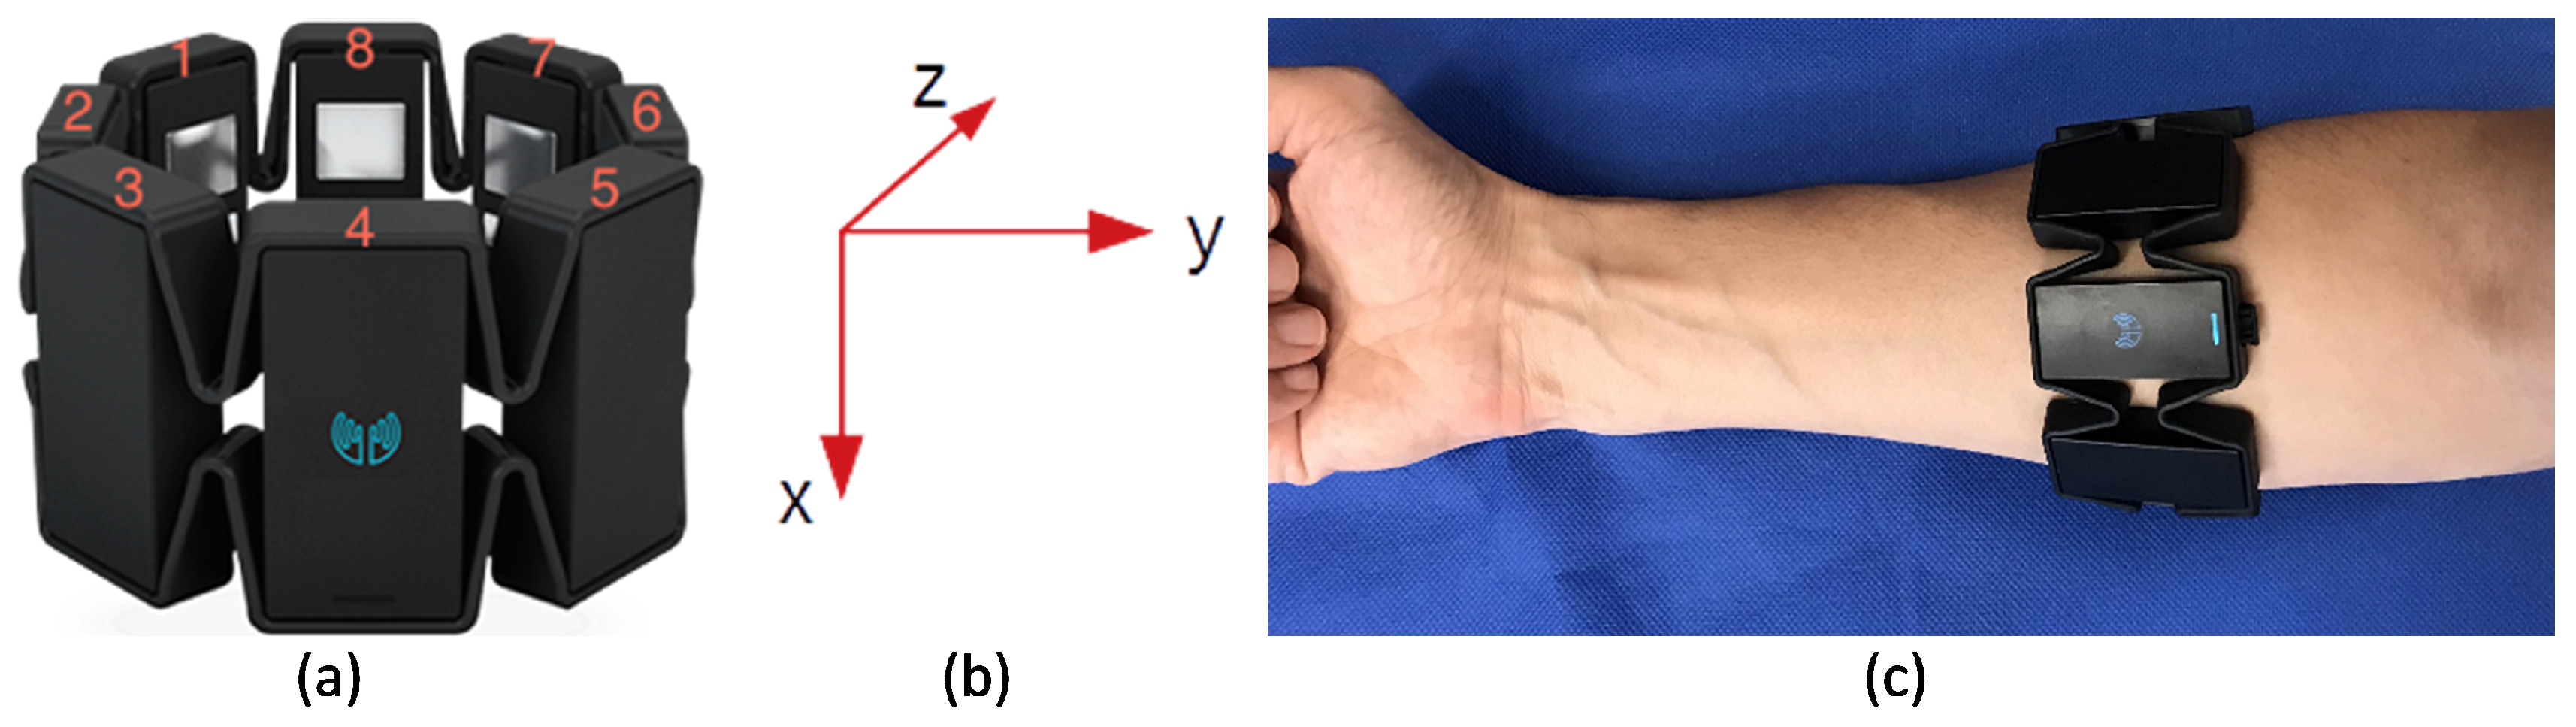

In [30]:
# # RIGHT
# i=7
# t=5
# s, m = atall[i][t], mtall[i][t]
# er = erall[i][t].iloc[:,[2,3,6,7]].copy()
# ir = imurall[i][t].iloc[:,4:7].copy()
# cut = 7 #nth beat

# #cut 3 bars from beginning and end & align & extract moving average
# remg = align(er, s, m, cut, end=True) #.rolling(5, min_periods=1).mean()
# rimu = align(ir, s, m, cut, end=True) #.rolling(4, min_periods=1).mean()

# emg_rms = live_rms(remg, window_length=50, hop_length=20, buffer_len=200, df=True, scale=True, sr=10).abs()

# # imu_mav = live_acc_mavg(rimu, window_size=5, scale=True, df=True, sr=50).abs()

# imu_filt = live_acc_filt(rimu, rect=True, scale=True, df=True, sr=50) #.abs()
# imu_ds = downsample(imu_filt, 5, sr=10, df=True) #.abs()

# remg3, rimu3 = matchLR(emg_rms, imu_ds)

# print(remg3.shape, rimu3.shape)

In [72]:
# LEFT
i=7
t=7
s, m = atall[i][t], mtall[i][t]
el = elall[i][t].iloc[:,[4, 5, 7, 0]].copy() # WHICH CHANNELS ON THE LEFT??
il = imulall[i][t].iloc[:,4:7].copy()
cut = 7 #nth beat

#cut 3 bars from beginning and end & align & extract moving average
lemg = align(el, s, m, cut, end=False) #.rolling(5, min_periods=1).mean()
limu = align(il, s, m, cut, end=False) #.rolling(4, min_periods=1).mean()

emg_rms = live_rms(lemg, window_length=50, hop_length=20, buffer_len=200, df=True, scale=True, sr=10).abs()

# imu_mav = live_acc_mavg(rimu, window_size=5, scale=True, df=True, sr=50).abs()

imu_filt = live_acc_filt(limu, rect=True, scale=True, df=True, sr=50) #.abs()
imu_ds = downsample(imu_filt, 5, sr=10, df=True) #.abs()

lemg3, limu3 = matchLR(emg_rms, imu_ds)

print(lemg3.shape, limu3.shape)

(1300, 4) (1300, 3)


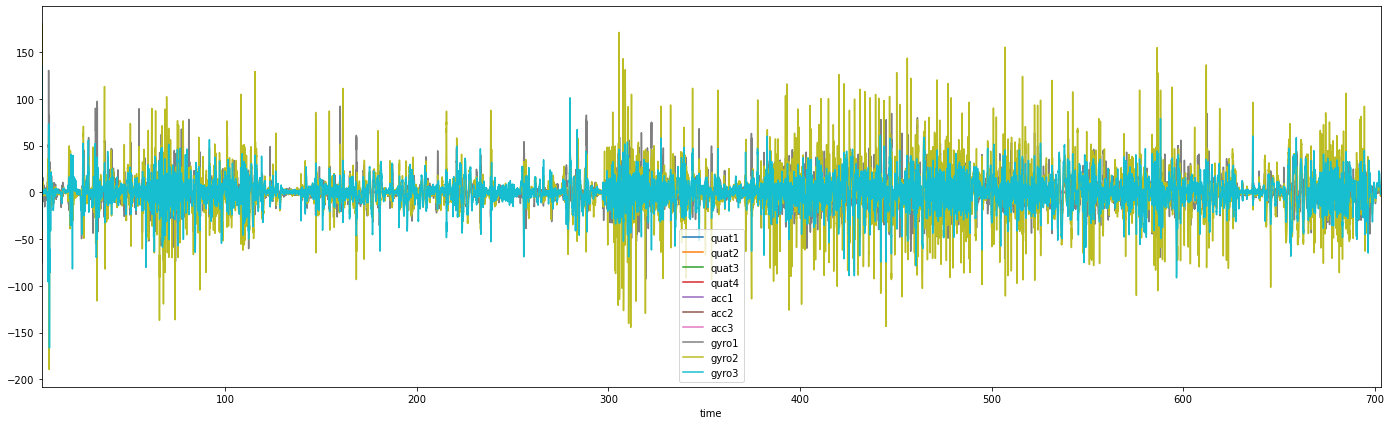

In [89]:
p(imulall[i][t])

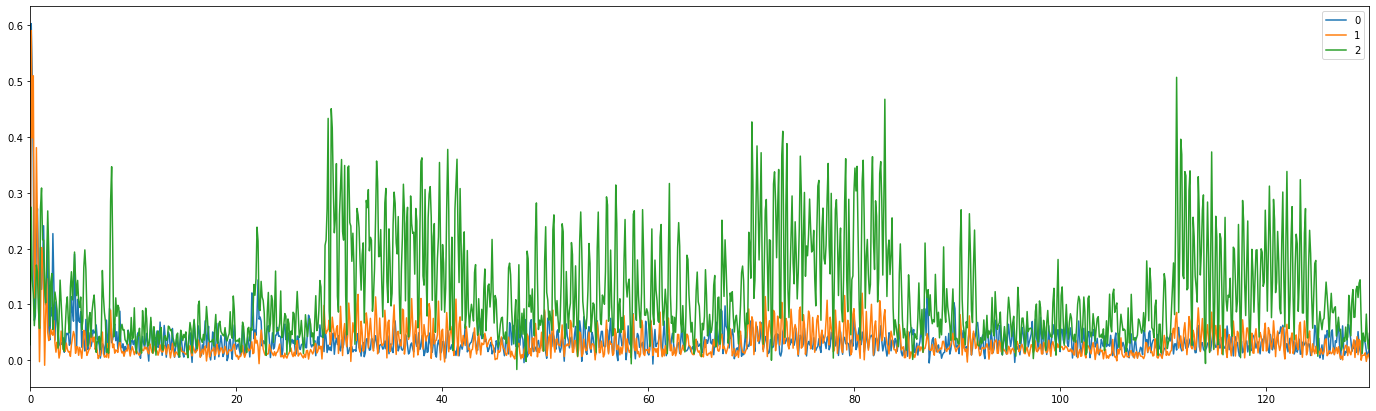

In [88]:
p(limu3)

(1300, 4)

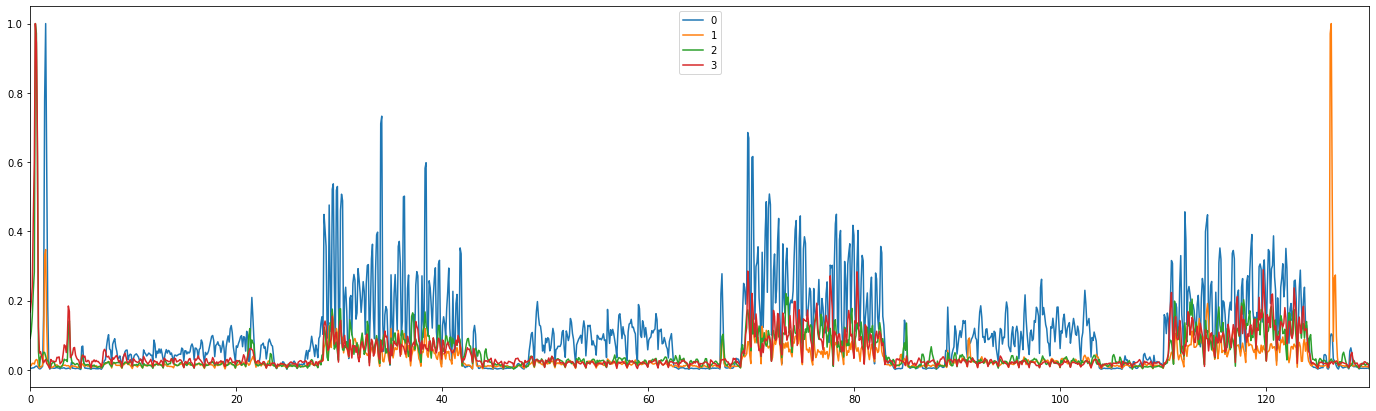

In [74]:
p(lemg3)
lemg3.shape

In [75]:
# RMSemg = live_rms(remg, window_length=4, hop_length=4, buffer_len=4, df=True, scale=True, sr=50)
# print(RMSemg.shape)
# p(RMSemg)

The recommended window length for calculating the RMS of an EMG signal is 120–300 ms
(Burden, Lewis, & Willcox, 2014)

In [76]:
# RMSimu = live_rms(rimu, window_length=2, hop_length=2, buffer_len=4, df=True, scale=False, sr=50)
# print(RMSimu.shape)
# p(RMSimu)

In [77]:
#Downsample to 10 Hz
start_time = time.time()

data_list=[]
for i,p in enumerate(task_qty[:]):
    
    concats=[]
    for t in range(p[1]):
        
        s, m = atall[i][t], mtall[i][t]
#         er = erall[i][t].iloc[:,[2,3,6,7]].copy() 
#         ir = imurall[i][t].iloc[:,4:7].copy()
        el = elall[i][t].iloc[:,[4, 5, 7, 0]].copy() 
        il = imulall[i][t].iloc[:,4:7].copy()
        cut = 7 #nth beat
        
        #cut 3 bars from beginning and end & align 
        lemg = align(el, s, m, cut, end=False)
        limu = align(il, s, m, cut, end=False)
        
        #RMS & scale emg
        emg_rms = live_rms(lemg, window_length=50, hop_length=20, buffer_len=200, df=True, scale=True, sr=10).abs()
        #MAVG & scale & downsample acc
#         imu_mav = live_acc_mavg(rimu, window_size=5, scale=True, df=True, sr=50).abs()
        #Filt & scale & downsample acc
        imu_filt = live_acc_filt(limu, rect=True, scale=True, df=True, sr=50)
        imu_ds = downsample(imu_filt, 5, sr=10, df=True)
        
        #sync EMG to ACC
        arremg, arrimu = matchLR(emg_rms, imu_ds)
        
        arremg = arremg.to_numpy()
        arrimu = arrimu.to_numpy()
        
        concat = np.concatenate((arremg, arrimu), axis=1)
        concats.append(concat)

    data_list.append(concats)
    
    printProgressBar(i,len(task_qty),"completed")

print("\n")
print("Execution of this program took %s seconds." % (time.time() - start_time))

[========= ] 96%  completed

Execution of this program took 36.60386085510254 seconds.


In [79]:
# allnan=[]
# for i,p in enumerate(task_qty):
#     nanlist=[]
#     for t in range(p[1]):
#         nans = fnan(data_list[i][t])
#         nanlist.append(nans)
#     allnan.append(nanlist)
# 'Clean!' if 1 not in allnan else 'Fuck!'

In [80]:
#Participant nr-1
peep=7

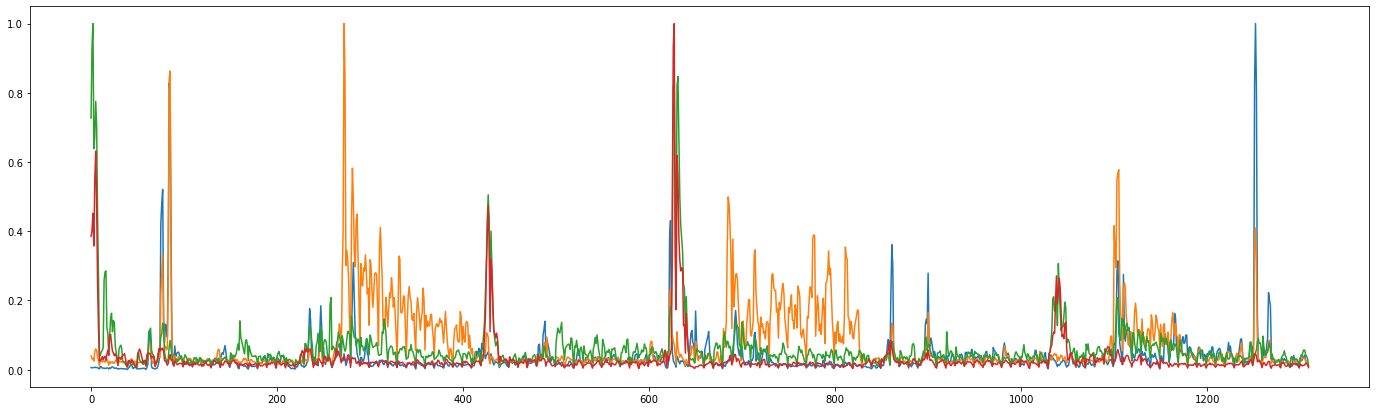

In [81]:
plt.figure(figsize=(24,7))
plt.plot(data_list[peep][5][:,:4])
plt.show();

In [82]:
# data_list[peep][5].iloc[:,:4].plot(figsize=(24,7));
# data_list[peep][5].iloc[:,:4].shape

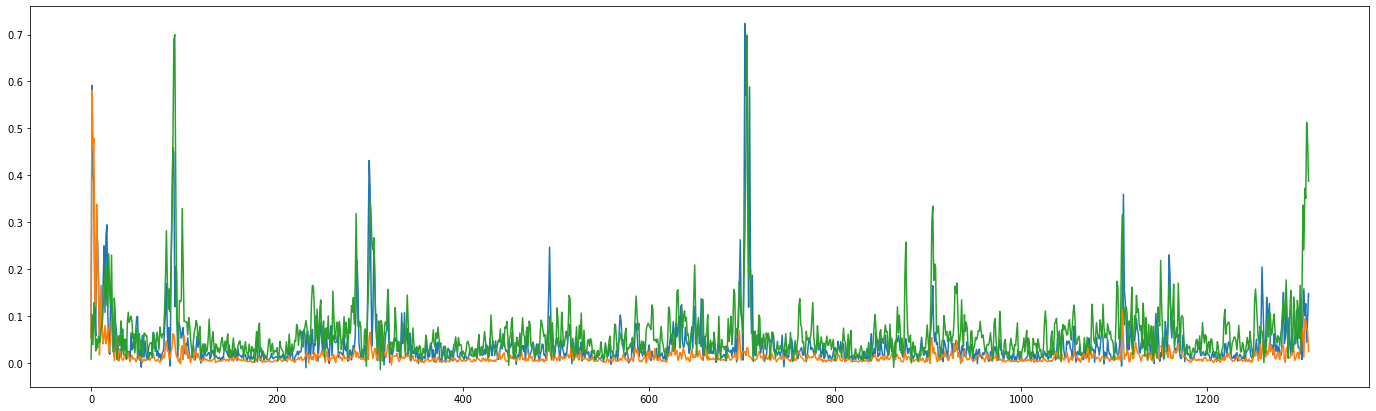

In [83]:
plt.figure(figsize=(24,7))
plt.plot(data_list[peep][5][:,4:])
plt.show();

In [84]:
# data_list[peep][5].iloc[:,4:].plot(figsize=(24,7));
# data_list[peep][5].iloc[:,4:].shape

### Export

In [85]:
decision = input('–Do you want to export? \n –')

if decision.startswith('y'):
    nr=0
    dataset_info=[]
    for i,p in enumerate(task_qty):
        for t in range(p[1]):
            nr += 1
            array = data_list[i][t]
            #save npy files
            np.save(os.path.join(savedir, 'sample_'+str(nr)), array)  
            dataset_info.append(str(nr) + '-' + str(p[0]) + '-' + str(all_tasks[t]))

    #save a txt file with the data info
    with open(os.path.join(savedir, "dataset_info.txt"), "w") as text_file:
        print(' \n'.join([str(elem) for elem in dataset_info]) , file=text_file)
else:
    pass

–Do you want to export? 
 –y
